# Generate user, item, and interaction datasets for car search domain
This notebook is one of several provided to demonstrate the use of Amazon Personalize to 
provide recommendations for users searching for cars. This notebook generates the user, item, 
and interactions data, saves them as local csv files, and uploads them to S3 for use
in creating Personalize datasets to drive Personalize recommendation models.

A denormalized form of the interaction data is also saved for use in testing the models
and evaluating the resulting recommendations.

In [3]:
import numpy as np
import pandas as pd
import json
import datetime
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

In [4]:
import boto3
import sagemaker

bucket   = sagemaker.Session().default_bucket() # or replace with your preferred s3 bucket
print(bucket)
prefix   = 'personalize/car'

sagemaker-us-east-1-355151823911


In [5]:
cars_filename         = 'car_items.csv'
users_filename        = 'users.csv'
interactions_filename = 'interactions.csv'
int_exp_filename      = 'interactions_expanded.csv'

## Define size for each generated dataset

In [6]:
NUM_INTERACTIONS = 750000
NUM_CARS         = 50000
NUM_USERS        = 30000

## Define various other parameters

Generated interactions are built as a set of "sessions". Each session is associated with
a single user and multiple car interactions. The timestamp for each interaction is 
separated by a configurable number of seconds.

In [7]:
SESSION_LEN           = 10
SESSION_DELAY_SECONDS = 2 * 60 # 2 minutes

NUM_SESSIONS = NUM_INTERACTIONS // SESSION_LEN

SECONDS_SINCE_OLDEST_INTERACTION = 60* 60 * 24 * 7 # a week ago
MOST_RECENT_TIMESTAMP = round(datetime.datetime.now().timestamp())

Define other parameters to control metadata for each car item.

In [8]:
MIN_YEAR    = 2009
MAX_YEAR    = 2019
MID_YEAR    = MIN_YEAR + ((MAX_YEAR - MIN_YEAR) // 2)

MIN_MILEAGE    = 1000
MAX_MILEAGE    = 200000
MILES_PER_YEAR = 15000

COLORS      = ['Red', 'Black', 'White', 'Blue']

In [9]:
MID_YEAR

2014

In [10]:
def date_to_string(ts):
    return datetime.datetime.fromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S')

## Configure the set of car makes and models, plus zip codes

The car item data is driven by a configurable set of models. You can define which
makes and models are used by editing the `models.csv` file provided.

In [11]:
models_df = pd.read_csv('models.csv')
models_df = shuffle(models_df)
print(models_df.shape)

NUM_MODELS = models_df.shape[0]
NUM_CLUSTERS = NUM_MODELS * 2  # for each model, have an old car cluster and new car cluster
print('\n{} clusters based on {} models.'.format(NUM_CLUSTERS, NUM_MODELS))
models_df.head(NUM_MODELS)

(50, 4)

100 clusters based on 50 models.


,MAKE,MODEL,NUM_DOORS,BODY_TYPE
0,Toyota,Camry,4,sedan
43,BMW,330i,4,sedan
24,Buick,Enclave,4,suv
42,Kia,Sedona,4,suv
17,Jeep,Cherokee,4,suv
12,Nissan,Altima,4,sedan
3,Honda,Odyssey,4,minivan
26,Buick,LaCrosse,4,sedan
38,Ford,Expedition,4,suv
7,Honda,Civic,4,sedan


The demo does not fully leverage location data for users and cars, but partial support
is provided in anticipation of adding that to the demo in the future.

In [12]:
zip_codes_df = pd.read_csv('zip_codes.csv')
print(zip_codes_df.shape)
zip_codes_df.head()

(100, 3)


,ZIP_CODE,CITY,INCOME
0,79936,El Paso TX,42857
1,90011,Los Angeles CA,23851
2,60629,Chicago IL,40279
3,90650,Norwalk CA,46012
4,90201,Bell Gardens CA,30029


## Generate data for the cars (items) dataset

### Generate make and model
Here we provide a normal distribution of Make/Model for our generated set of cars.
The mean is the midpoint of the number of total models, and the standard deviation is 
a quarter of the number of models. We make sure that no generated model falls outside the
bounds of the actual number of models.

In [13]:
def gen_normal_make_and_model():
    _idx = int(np.random.normal(NUM_MODELS // 2, NUM_MODELS // 4))
    _idx = min(NUM_MODELS - 1, _idx)
    _idx = max(0, _idx)
    return _idx

### Generate price
Here we determine a random price pased on age and miles.

In [14]:
def gen_price(age, miles):
    _price = 40000 - (3000 * age) + np.random.randint(0, 10000)
    _price = max(10000, _price)
    return _price

### Core function for generating cars (items)
Here we generate the set of items / cars to be recommended. We normally distribute the 
year of manufacture, and generate a random set of miles driven by the age of the car.

In [15]:
def gen_cars(num_cars):
    _car_inventory = []
    
    for i in range(num_cars):
        _year      = int(np.random.normal(2014, 2))
        _year      = min(MAX_YEAR, _year)
        
        _age       = MAX_YEAR - _year
        _mileage   = (MILES_PER_YEAR * _age) + np.random.randint(0, 10000)
        _price     = gen_price(_age, _mileage) 

        _model_idx = gen_normal_make_and_model()
        
#        _color_idx = np.random.randint(0, len(COLORS))
#        _loc_idx   = np.random.randint(0, _zip_len)
        
        _this_car = [str(i), models_df.iloc[_model_idx][0].strip(), 
                     models_df.iloc[_model_idx][1].strip(),
                     str(_year), _mileage, _price]
        #, COLORS[_color_idx], zip_codes_df.iloc[_loc_idx][0]]

        _car_inventory.append(_this_car)

    # not including color and location, due to personalize limit on num fields
    _df = pd.DataFrame(_car_inventory, columns=['ITEM_ID', 'MAKE', 'MODEL', 
                                                'YEAR', 'MILEAGE', 'PRICE'])
    return _df

In [16]:
cars_df = gen_cars(NUM_CARS)
print(cars_df.shape)
cars_df.head()

(50000, 6)


,ITEM_ID,MAKE,MODEL,YEAR,MILEAGE,PRICE
0,0,Volkswagen,Golf,2015,64883,29265
1,1,Honda,Pilot,2010,140968,16293
2,2,Dodge,Ram,2013,98521,29198
3,3,Dodge,Ram,2016,52822,39471
4,4,Chevrolet,Camaro,2015,66982,30708


### Look at distribution of each car (item) feature

In [17]:
cars_df['MAKE'].value_counts()

Ford          9074
Chevrolet     6432
Toyota        4238
Chrysler      3835
Dodge         3461
Honda         2990
Hyundai       2833
Buick         2504
Nissan        2277
Volkswagen    2146
Cadillac      2015
GMC           1859
BMW           1852
Volvo         1731
Subaru        1526
Jeep           882
Kia            345
Name: MAKE, dtype: int64

In [18]:
cars_df['MODEL'].value_counts()

Pacifica          1701
Mustang           1686
Explorer          1683
Tahoe             1654
Suburban          1651
Regal             1631
430i              1607
Santa Fe          1607
Corrola           1574
Outback           1526
F150              1505
Rogue             1478
Pilot             1455
Silverado         1394
Ram               1360
200               1347
Camaro            1301
Escape            1270
Elantra           1226
Edge              1211
XT5               1196
Golf              1147
Durango           1146
Camry             1117
Fusion            1061
240               1055
Yukon              989
Caravan            955
Acadia             870
Escalade           819
300                787
Prius              758
Civic              701
V60                676
Expedition         658
Tiguan             623
LaCrosse           587
Sienna             547
Odyssey            516
Grand Cherokee     513
Altima             454
Traverse           432
Jetta              376
Cherokee   

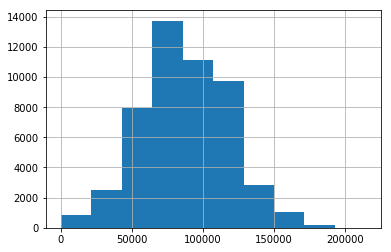

In [19]:
cars_df['MILEAGE'].hist()

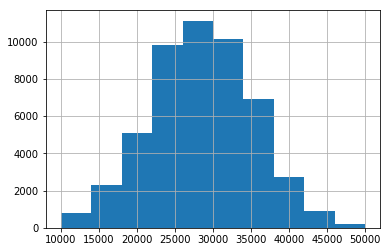

In [20]:
cars_df['PRICE'].hist()

## Generate data for users dataset
Here we normally distribute age of users, and uniformly distribute gender and location.

In [21]:
def gen_users(num_users):
    _users = []
    
    _zip_len = zip_codes_df.shape[0]
    
    for i in range(num_users):
        _age        = int(np.random.normal(40, 4))
        _gender_idx = np.random.randint(0, 2)
        _loc_idx    = np.random.randint(0, _zip_len)
        if _gender_idx == 0:
            _gender = 'MALE'
        else:
            _gender = 'FEMALE'
            
        _this_user = [str(i), _age, _gender, 
                      str(zip_codes_df.iloc[_loc_idx][0]), 
                      zip_codes_df.iloc[_loc_idx][2]]
        
        _users.append(_this_user)
        
    _df = pd.DataFrame(_users, columns=['USER_ID', 'AGE', 'GENDER', 'LOCATION', 'SALARY'])
    return _df

In [22]:
users_df = gen_users(NUM_USERS)
print(users_df.shape)
users_df.head()

(30000, 5)


,USER_ID,AGE,GENDER,LOCATION,SALARY
0,0,44,MALE,92553,38554
1,1,41,FEMALE,92509,45995
2,2,40,FEMALE,10453,21109
3,3,35,FEMALE,60647,35283
4,4,43,FEMALE,60625,40083


### Look at the distribution of each user feature

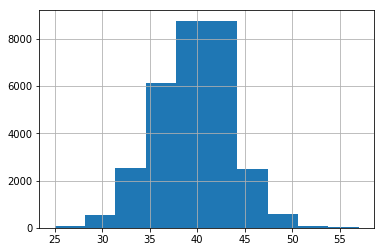

In [23]:
users_df['AGE'].hist()

In [24]:
users_df['LOCATION'].value_counts()[0:10]

77479    350
60647    341
11219    339
11226    331
91710    327
91342    326
87121    325
91744    324
75217    322
94565    321
Name: LOCATION, dtype: int64

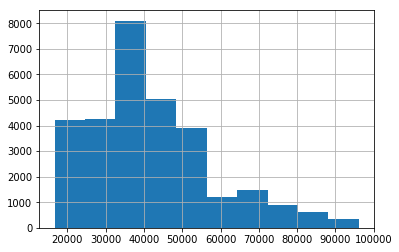

In [25]:
users_df['SALARY'].hist()

In [26]:
print('Car count: {}, User count: {}'.format(NUM_CARS, NUM_USERS))

Car count: 50000, User count: 30000


## Generate interactions dataset

### Helper function for normal distribution of interaction items

In [27]:
def gen_normal_item_indices(num_indices, num_items, std_div=10):
    _loc = num_indices // 2
    _std = num_indices // std_div

    _tmp = np.random.normal(loc=_loc, scale=_std, size=num_items)
    _tmp = _tmp.astype(int)

#    num_bins = 50
#    _a, _b, _c = plt.hist(_tmp, num_bins)
    
    return _tmp

### Add columns to users that will drive a predictable set of interactions
Interactions will be generated on a per-user basis. Here we define what set of cars
a user will be viewing. We do this by defining a set of "car clusters". A car cluster
is the set of cars that all have the same make and model, plus an age preference.
For example, some users will prefer Old Toyota Camry's. Others will like New Ford Explore's.

The `FAV_CLUSTER` feature is an integer representing the user's favorit car cluster. The `FAV` 
feature is a text version that makes it easier to understand the car cluster when looking
at the data during testing and model assessment. These features are NOT saved as part of
the Amazon Personalize datasets, but ARE saved as part of the expanded interactions data
that is saved for helping in the model usage notebook.

47    769
49    762
48    755
52    733
51    732
44    732
53    725
54    719
45    715
43    706
50    702
56    702
42    697
46    696
57    684
55    677
58    659
41    659
40    631
39    599
59    599
38    580
60    562
62    561
61    554
36    527
35    527
37    526
64    519
63    504
     ... 
84     62
85     58
13     54
87     50
12     50
86     48
10     46
99     43
11     41
88     40
0      34
91     33
7      33
9      30
89     30
92     28
8      26
90     26
94     22
6      19
96     16
93     13
95     13
5      13
2      12
3       9
97      8
4       8
1       7
98      3
Name: FAV_CLUSTER, Length: 100, dtype: int64

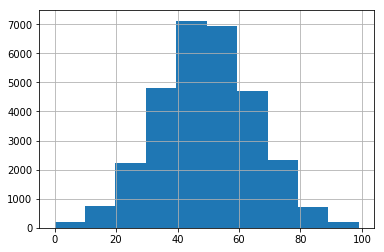

In [28]:
def set_fav(user_id):
    _fav = int(np.random.normal(NUM_CLUSTERS // 2, NUM_CLUSTERS // 6))
    _fav = min(NUM_CLUSTERS - 1, _fav)
    _fav = max(0, _fav)
    return _fav

users_df['FAV_CLUSTER'] = users_df['USER_ID'].apply(set_fav)
users_df['FAV_CLUSTER'].hist()
users_df['FAV_CLUSTER'].value_counts()

24    1517
23    1465
26    1458
22    1447
25    1434
21    1403
27    1396
28    1386
20    1290
29    1258
19    1179
30    1116
31    1065
18    1053
17     987
32     984
16     828
33     827
15     777
34     729
35     629
14     588
13     583
36     568
37     436
12     427
38     367
11     360
39     320
10     281
40     238
9      225
8      182
41     175
7      147
42     120
6      104
43      98
5       87
44      70
45      59
4       56
3       52
49      46
0       41
46      41
47      35
48      24
1       21
2       21
Name: FAV_MODEL, dtype: int64

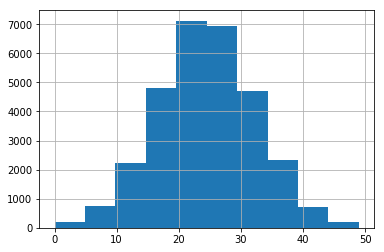

In [29]:
users_df['FAV_MODEL'] = users_df['FAV_CLUSTER'] // 2
users_df['FAV_MODEL'].hist()
users_df['FAV_MODEL'].value_counts()

In [30]:
def set_fav_text(cluster):
    fav_model = cluster // 2
    if cluster % 2 == 0:
        age = 'NEWISH'
    else:
        age = 'OLDISH'
    return  '{}-{}-{}'.format(age,
                              models_df.iloc[fav_model]['MAKE'], 
                              models_df.iloc[fav_model]['MODEL'])
users_df['FAV'] = users_df['FAV_CLUSTER'].apply(set_fav_text)
users_df['FAV'].value_counts()

OLDISH-Chrysler-Pacifica      769
OLDISH-Ford-Mustang           762
NEWISH-Ford-Mustang           755
NEWISH-Ford-Explorer          733
OLDISH-BMW-430i               732
NEWISH-Chevrolet-Suburban     732
OLDISH-Ford-Explorer          725
NEWISH-Chevrolet-Tahoe        719
OLDISH-Chevrolet-Suburban     715
OLDISH-Nissan-Rogue           706
NEWISH-Buick-Regal            702
NEWISH-BMW-430i               702
NEWISH-Nissan-Rogue           697
NEWISH-Chrysler-Pacifica      696
OLDISH-Buick-Regal            684
OLDISH-Chevrolet-Tahoe        677
OLDISH-Toyota-Corrola         659
NEWISH-Hyundai-Santa Fe       659
NEWISH-Toyota-Corrola         631
OLDISH-Hyundai-Santa Fe       599
OLDISH-Ford-F150              599
NEWISH-Ford-F150              580
NEWISH-Subaru-Outback         562
NEWISH-Chrysler-200           561
OLDISH-Subaru-Outback         554
OLDISH-Chevrolet-Silverado    527
NEWISH-Honda-Pilot            527
OLDISH-Honda-Pilot            526
NEWISH-Dodge-Ram              519
OLDISH-Chrysle

### Helper functions

In [31]:
def print_item(item_id):
    tmp = cars_df[cars_df.ITEM_ID == item_id].iloc[0]
    print('Id: {}, Make: {}, Model: {}, Miles: {}, Year: {}, Price: {}, Age: {}'.format(item_id,
         tmp['MAKE'], tmp['MODEL'], tmp['MILEAGE'], tmp['YEAR'], tmp['PRICE'], tmp['AGE']))

In [32]:
def print_car_cluster(c):
    print(len(c))
    print(c)

### Generate a normal distribution of random cars for a given car cluster

In [33]:
import scipy.stats as stats
import math
import statistics

In [34]:
def gen_normal_from_cluster(_fav_cars, _which_cluster, _sample_size):
    _car_cluster = _fav_cars[_which_cluster].reset_index(drop=True)
    _cluster_len = len(_car_cluster)

    _mu = _cluster_len // 2
    _sigma = _cluster_len // 10

    _idx_list = np.random.normal(loc  =_mu, 
                                 scale=_sigma, 
                                 size =_sample_size)
    _idx_list = _idx_list.astype(int)
        
    # We want to maximize how many specific car items are involved in the generated
    # interactions. However, the more we push the envelope, the more likely it is that
    # a generated index is outside of bounds. Here we catch and resolve those situations.
    i = 0
    while max(_idx_list) > (_cluster_len - 1):
        i += 1
        if i > 6:
            print('==correcting max {}, i {}, cluster len: {}, sample size {}'.format(
                max(_idx_list), i, _cluster_len, _sample_size))
        _idx_of_max = np.argmax(_idx_list)
        _idx_list[_idx_of_max] = np.random.randint(0, (_cluster_len -1))
        
    return _car_cluster.iloc[_idx_list]['ITEM_ID'].values

In [35]:
def gen_normal_from_cluster_v2(_fav_cars, _which_cluster, _sample_size):
    _car_cluster = _fav_cars[_which_cluster].reset_index(drop=True)
    _cluster_len = len(_car_cluster)

    _mu = statistics.mean(_car_cluster.index)
    _sigma = statistics.stdev(_car_cluster.index)

    _low_clip = (0 - _mu) / _sigma
    _hi_clip  = (_cluster_len - 1 - _mu) / _sigma
    
    _idx_list = stats.truncnorm.rvs(_low_clip, _hi_clip, 
                                    loc=_mu, scale=_sigma, 
                                    size=_sample_size)
    _idx_list = _idx_list.astype(int)
            
    return _car_cluster.iloc[_idx_list]['ITEM_ID'].values

### Core function for generating interactions

In [36]:
def gen_interactions(num_interactions):
    _interactions = []
    
    _num_users = users_df.shape[0]
    _num_items = cars_df.shape[0]
    
    # generate interactions as sets of interactions separated by a few mins
    # by same user on different items
    _session_len = SESSION_LEN
    _num_sessions = num_interactions // _session_len
    print('Generating {} sessions of length {}, total: {}...'.format(_num_sessions, 
                                                                     _session_len,
                                                                     num_interactions))

    # One-time generation of the list of cars that match each possible cluster of
    # favorite cars. A random selection of these will be used in each session.
    _fav_cars = []
    for c in range(NUM_CLUSTERS):
        m = c // 2
        _make  = models_df.iloc[m]['MAKE']
        _model = models_df.iloc[m]['MODEL']
        if c % 2 == 0:
            # newish
            _car_cluster = cars_df[(cars_df.YEAR >= str(MID_YEAR)) &
                                       (cars_df.MAKE  == _make) &
                                       (cars_df.MODEL == _model)]
        else:
            # oldish
            _car_cluster = cars_df[(cars_df.YEAR < str(MID_YEAR)) &
                                       (cars_df.MAKE  == _make) &
                                       (cars_df.MODEL == _model)]

        _fav_cars.append(_car_cluster)

    # Generate a set of user_id's to be used, one per session
    _which_user_idx = gen_normal_item_indices(_num_users, _num_sessions, std_div=5)

    # Session start times will be randomly picked to happen between now and a configurable
    # time in the past
    _most_recent_time = MOST_RECENT_TIMESTAMP - (60 * 60 * 2) - \
                            ((SESSION_LEN + 1) * SESSION_DELAY_SECONDS)
    _oldest_time      = _most_recent_time - SECONDS_SINCE_OLDEST_INTERACTION
    
    print('Oldest session starts: {}, Newest: {}'.format(date_to_string(_oldest_time),
                                                         date_to_string(_most_recent_time)))
    
    for s in range(_num_sessions):
        if (s % 10000 == 0):
            print('...at session {}'.format(s))
            
        _user = _which_user_idx[s]
        
        # ensure user id is within bounds
        if (_user < 0) or (_user > (NUM_USERS - 1)):
            _user = np.random.randint(10, NUM_USERS - 10)
            
        # Use same car cluster for every interaction in the current session
        _which_cluster  = users_df.iloc[_user]['FAV_CLUSTER']

        # Pick a random session start time
        _when = np.random.randint(_oldest_time, _most_recent_time)
        
        # Generate a set of specific cars to use in this session. Choose them
        # only from the designated car cluster preferred by this user.
        _sample_size = num_interactions // NUM_CLUSTERS
        _session_cars = gen_normal_from_cluster(_fav_cars, _which_cluster, _sample_size)

        for i in range(_session_len):
            interaction_num = (s * _session_len) + i
            idx = interaction_num % NUM_CLUSTERS

            _item = _session_cars[idx]

            _when = _when + (i * SESSION_DELAY_SECONDS) 

            _this_interaction = [str(_user), str(_item), _when, s]

            _interactions.append(_this_interaction)
        
    _df = pd.DataFrame(_interactions, columns=['USER_ID', 'ITEM_ID', 'TIMESTAMP', 'SESSION_ID'])
    return _df

In [37]:
%%time
interactions_df = gen_interactions(NUM_INTERACTIONS)
interactions_df.head()

Generating 75000 sessions of length 10, total: 750000...
Oldest session starts: 2019-07-10 09:52:18, Newest: 2019-07-17 09:52:18
...at session 0
...at session 10000
...at session 20000
...at session 30000
...at session 40000
...at session 50000
...at session 60000
...at session 70000
CPU times: user 3min 27s, sys: 176 ms, total: 3min 27s
Wall time: 3min 27s


### Show utilization and distribution of interactions per user and per item

In [38]:
_user_vc = interactions_df['USER_ID'].value_counts()
print('** {:.2f} of users have interactions ({}/{})\n'.format(_user_vc.shape[0]/NUM_USERS,
                                                        _user_vc.shape[0],
                                                        NUM_USERS))
print('First 5: \n{}'.format(_user_vc[:5]))
print('Last 5:  \n{}'.format(_user_vc[-5:]))

** 0.78 of users have interactions (23364/30000)

First 5: 
15874    160
12102    140
20068    140
17032    140
17106    140
Name: USER_ID, dtype: int64
Last 5:  
28864    10
7695     10
20660    10
27196    10
24073    10
Name: USER_ID, dtype: int64


In [39]:
print('** {:.2f} of ITEMS have interactions ({}/{})\n'.format(interactions_df['ITEM_ID'].value_counts().shape[0]/NUM_CARS,
                                                      interactions_df['ITEM_ID'].value_counts().shape[0],
                                                       NUM_CARS))
_item_vc = interactions_df['ITEM_ID'].value_counts()
print('First 5: \n{}'.format(_item_vc[:5]))
print('Last 5:  \n{}'.format(_item_vc[-5:]))

** 0.58 of ITEMS have interactions (29135/50000)

First 5: 
25714    122
25104    113
24588    113
25589    113
26377    113
Name: ITEM_ID, dtype: int64
Last 5:  
11457    1
37436    1
8156     1
11351    1
8240     1
Name: ITEM_ID, dtype: int64


## Drop inactive users and items

In [40]:
active_users   = pd.DataFrame(interactions_df['USER_ID'].value_counts()).index
inactive_users = users_df[~users_df.USER_ID.isin(active_users)]
print('{} users have NO interactions'.format(inactive_users.shape[0]))
inactive_users.head()

6636 users have NO interactions


,USER_ID,AGE,GENDER,LOCATION,SALARY,FAV_CLUSTER,FAV_MODEL,FAV
0,0,44,MALE,92553,38554,26,13,NEWISH-Volvo-240
1,1,41,FEMALE,92509,45995,64,32,NEWISH-Dodge-Ram
2,2,40,FEMALE,10453,21109,47,23,OLDISH-Chrysler-Pacifica
4,4,43,FEMALE,60625,40083,29,14,OLDISH-Volkswagen-Golf
5,5,33,FEMALE,22193,67190,56,28,NEWISH-Buick-Regal


count    23364.000000
mean        32.100668
std         20.928966
min         10.000000
25%         10.000000
50%         30.000000
75%         40.000000
max        160.000000
Name: USER_ID, dtype: float64

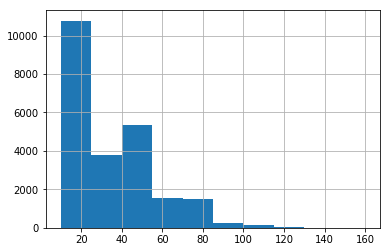

In [41]:
active_users_df = pd.DataFrame(interactions_df['USER_ID'].value_counts()).reset_index()
active_users_df['USER_ID'].hist()
active_users_df.head()
active_users_df['USER_ID'].describe()

In [42]:
active_items   = pd.DataFrame(interactions_df['ITEM_ID'].value_counts()).index
inactive_items = cars_df[~cars_df.ITEM_ID.isin(active_items)]
print('{} items have NO interactions'.format(inactive_items.shape[0]))
inactive_items.head()

20865 items have NO interactions


,ITEM_ID,MAKE,MODEL,YEAR,MILEAGE,PRICE
0,0,Volkswagen,Golf,2015,64883,29265
1,1,Honda,Pilot,2010,140968,16293
2,2,Dodge,Ram,2013,98521,29198
3,3,Dodge,Ram,2016,52822,39471
4,4,Chevrolet,Camaro,2015,66982,30708


count    29135.000000
mean        25.742234
std         25.912569
min          1.000000
25%          4.000000
50%         16.000000
75%         42.000000
max        122.000000
Name: ITEM_ID, dtype: float64

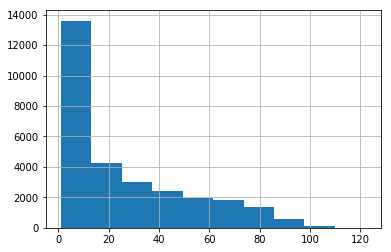

In [43]:
active_items_df = pd.DataFrame(interactions_df['ITEM_ID'].value_counts()).reset_index()
active_items_df['ITEM_ID'].hist()
active_items_df.head()
active_items_df['ITEM_ID'].describe()

In [44]:
cars_df.drop(inactive_items.index, inplace=True)
print('After dropping inactive cars, {} remain.'.format(cars_df.shape))

After dropping inactive cars, (29135, 6) remain.


In [45]:
users_df.drop(inactive_users.index, inplace=True)
print('After dropping inactive users, {} remain.'.format(users_df.shape))

After dropping inactive users, (23364, 8) remain.


## Create an expanded interactions dataframe for analysis
The interactions dataframe to pass to Personalize is limited to 5 metadata items
and is conforming to a schema we will define in another notebook. This expanded 
dataframe helps with framing tests and evaluating results, as in creates one big
denormalized dataframe with interactions and corresponding user and car features.

In [46]:
interactions_expanded_df = pd.merge(interactions_df, cars_df, on='ITEM_ID')
interactions_expanded_df = pd.merge(interactions_expanded_df, users_df, on='USER_ID')
interactions_expanded_df.head()

,USER_ID,ITEM_ID,TIMESTAMP,SESSION_ID,MAKE,MODEL,YEAR,MILEAGE,PRICE,AGE,GENDER,LOCATION,SALARY,FAV_CLUSTER,FAV_MODEL,FAV
0,26969,26016,1563028044,0,Nissan,Rogue,2012,108153,21028,40,FEMALE,11368,34746,43,21,OLDISH-Nissan-Rogue
1,26969,24366,1563028164,0,Nissan,Rogue,2013,90035,31167,40,FEMALE,11368,34746,43,21,OLDISH-Nissan-Rogue
2,26969,22456,1563028404,0,Nissan,Rogue,2013,98834,31490,40,FEMALE,11368,34746,43,21,OLDISH-Nissan-Rogue
3,26969,24100,1563028764,0,Nissan,Rogue,2012,110746,27289,40,FEMALE,11368,34746,43,21,OLDISH-Nissan-Rogue
4,26969,34277,1563029244,0,Nissan,Rogue,2013,97902,28327,40,FEMALE,11368,34746,43,21,OLDISH-Nissan-Rogue


## Display overall statistics

In [47]:
eps_stats = pd.DataFrame(interactions_df['SESSION_ID'].value_counts()).describe()
epi_stats = pd.DataFrame(interactions_df['ITEM_ID'].value_counts()).describe()
epu_stats = pd.DataFrame(interactions_df['USER_ID'].value_counts()).describe()
spu_stats = interactions_df.groupby('USER_ID')['SESSION_ID'].nunique().to_frame().describe()

In [48]:
item_count = cars_df.shape[0]
user_count = users_df.shape[0]
interaction_count = interactions_df.shape[0]

print('{:,} items\n{:,} users\n{:,} interactions\n{:,} sessions'.format(item_count, 
                                                                user_count, 
                                                                interaction_count, 
                                                                NUM_SESSIONS))
print('\nevents per session (median/mean/stdev) {:.2f}/{:.2f}/{:.2f}'.format(eps_stats.loc['mean'].values[0],
                                                               eps_stats.loc['50%'].values[0],
                                                               eps_stats.loc['std'].values[0]))
print('events per item    (median/mean/stdev) {:.2f}/{:.2f}/{:.2f}'.format(epi_stats.loc['mean'].values[0],
                                                                           epi_stats.loc['50%'].values[0],
                                                                           epi_stats.loc['std'].values[0]))
print('events per user    (median/mean/stdev) {:.2f}/{:.2f}/{:.2f}'.format(epu_stats.loc['mean'].values[0],
                                                                           epu_stats.loc['50%'].values[0],
                                                                           epu_stats.loc['std'].values[0]))
print('sessions per user  (median/mean/stdev) {:.2f}/{:.2f}/{:.2f}'.format(spu_stats.loc['mean'].values[0],
                                                                           spu_stats.loc['50%'].values[0],
                                                                           spu_stats.loc['std'].values[0]))

print('\n{:.2f} of items have interactions ({}/{})'.format(interactions_df['ITEM_ID'].value_counts().shape[0]/item_count,
                                                      interactions_df['ITEM_ID'].value_counts().shape[0],
                                                       item_count))
print('{:.2f} of users have interactions ({}/{})'.format(_user_vc.shape[0]/user_count,
                                                        _user_vc.shape[0],
                                                        user_count))

29,135 items
23,364 users
750,000 interactions
75,000 sessions

events per session (median/mean/stdev) 10.00/10.00/0.00
events per item    (median/mean/stdev) 25.74/16.00/25.91
events per user    (median/mean/stdev) 32.10/30.00/20.93
sessions per user  (median/mean/stdev) 3.21/3.00/2.09

1.00 of items have interactions (29135/29135)
1.00 of users have interactions (23364/23364)


## Check out the interaction timestamp distribution

In [49]:
def hours_ago(ts):
    _time_diff_seconds = MOST_RECENT_TIMESTAMP - ts
    return _time_diff_seconds / 60 / 60

interactions_expanded_df['HOURS_AGO'] = interactions_expanded_df['TIMESTAMP'].apply(hours_ago)

In [50]:
interactions_expanded_df['WHEN'] = interactions_expanded_df['TIMESTAMP'].apply(date_to_string)

In [51]:
interactions_expanded_df[['TIMESTAMP','WHEN','HOURS_AGO']].sort_values('TIMESTAMP')

,TIMESTAMP,WHEN,HOURS_AGO
510166,1562752340,2019-07-10 09:52:20,170.366111
468681,1562752340,2019-07-10 09:52:20,170.366111
430707,1562752344,2019-07-10 09:52:24,170.365000
725213,1562752347,2019-07-10 09:52:27,170.364167
479450,1562752358,2019-07-10 09:52:38,170.361111
263400,1562752361,2019-07-10 09:52:41,170.360278
662098,1562752370,2019-07-10 09:52:50,170.357778
738213,1562752372,2019-07-10 09:52:52,170.357222
480433,1562752372,2019-07-10 09:52:52,170.357222
702580,1562752373,2019-07-10 09:52:53,170.356944


In [52]:
interactions_expanded_df[interactions_expanded_df.HOURS_AGO < 0]

,USER_ID,ITEM_ID,TIMESTAMP,SESSION_ID,MAKE,MODEL,YEAR,MILEAGE,PRICE,AGE,GENDER,LOCATION,SALARY,FAV_CLUSTER,FAV_MODEL,FAV,HOURS_AGO,WHEN


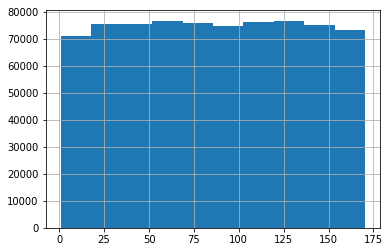

In [53]:
interactions_expanded_df['HOURS_AGO'].hist()

## Save data to S3 and expanded interactions to local csv

In [54]:
cars_df.to_csv(cars_filename, index=False)
boto3.Session().resource('s3').Bucket(bucket).Object('{}/{}'.format(prefix, cars_filename)).upload_file(cars_filename)

In [55]:
users_df.to_csv(users_filename, index=False)
boto3.Session().resource('s3').Bucket(bucket).Object('{}/{}'.format(prefix, users_filename)).upload_file(users_filename)

In [56]:
interactions_df[['USER_ID', 'ITEM_ID', 'TIMESTAMP']].to_csv(interactions_filename, index=False)
boto3.Session().resource('s3').Bucket(bucket).Object('{}/{}'.format(prefix, interactions_filename)).upload_file(interactions_filename)

In [57]:
interactions_expanded_df.to_csv(int_exp_filename, index=False)